In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from flow import sample_images
from transforms import radon
from utils import load_checkpoint
from torchdiffeq import odeint
import time
from torch import optim
from torchmetrics import CatMetric
from unet import Unet

In [9]:
torch.manual_seed(159753)
np.random.seed(159753)

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:

%%capture
checkpoint_path = 'checkpoints/32x32/ckp_3906.tar'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(ch=32).to(device)

# ema_model = torch.optim.swa_utils.AveragedModel(
#     model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.9999)
# )
_, _, model, _, _, _= load_checkpoint(model=model, path=checkpoint_path)
model.eval()

In [ ]:
from typing import Callable, Dict, List, Optional

from torch import autocast
from torchdiffeq import odeint_adjoint 
import torch.nn as nn

def inverse_loss_fn(x, y):
    """
    Loss function for the inverse problem.
    """
    device = x.device
    if isinstance(x, np.ndarray):
        x= torch.tensor(x, device=device, dtype=torch.float32)
    if isinstance(y, np.ndarray):
        y = torch.tensor(y, device=device, dtype=torch.float32)

    x = x.float()
    y = y.float()


    loss = torch.mean((x - y) ** 2)

    return loss
    
def ode_integrate(ode_func: nn.Module,
                  init_x: torch.Tensor,
                  ode_opts: Dict = {},
                  t_eps: float = 0,
                  init_t: float = 0.,
                  final_t: float = 1.,
                  t_arr: Optional[List[float]] = None,
                  num_steps: int = 5,
                  intermediate_points: bool = False
      ) -> torch.Tensor:

    if t_arr is None:
        t = torch.linspace(init_t - t_eps, final_t, num_steps).to(init_x.device)
    else:
        t = torch.tensor(t_arr, dtype=torch.float32, device=init_x.device)

    ode_opts = {
        "atol": 1e-5, 
        "rtol": 1e-5, 
        "method": "euler", 
        **ode_opts
    }

    z = odeint(
        func = lambda t, x: ode_func(x, t.expand(x.shape[0])),
        y0 = init_x,
        t = t,
        **ode_opts
    )

    if not intermediate_points:
        return z[-1]
    return z


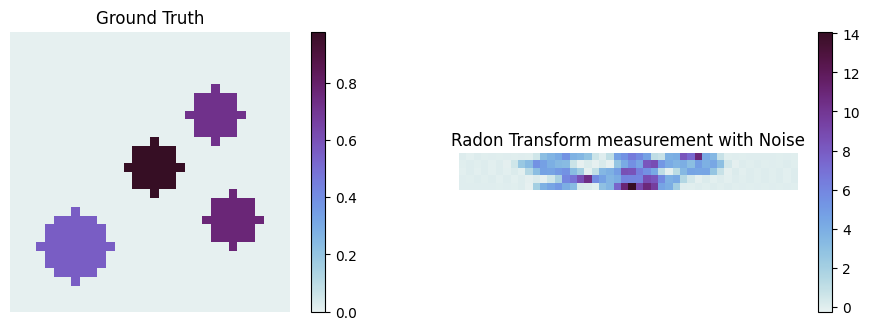

In [12]:
# load data and select a random ground truth from test set
test_data = torch.load('data/dataset-32.pt')["test"]
idx = np.random.randint(0, len(test_data))
gt = test_data[idx].to(device).unsqueeze(0)

# apply radon transform, and apply multiplicative noise
img_radon = radon.radon_transform(gt.squeeze().cpu().numpy(), N=5)
img_radon = torch.tensor(img_radon, device=device, dtype=torch.float32).unsqueeze(0)
img_radon = img_radon.unsqueeze(0)  # add batch dimension   

# mult noise
img_radon = (1 + 0.1 * torch.randn_like(img_radon)) * img_radon
# plot gt, plot img_radon, plot initial guess in x_0 space, and plot flow realization
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(gt.squeeze().cpu().numpy(), cmap=cmocean.cm.dense)
plt.title('Ground Truth')
plt.axis('off')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(img_radon.squeeze().cpu().numpy(), cmap=cmocean.cm.dense)
plt.title('Radon Transform measurement with Noise')
plt.axis('off')
plt.colorbar()

In [ ]:
# getting normalization constants
train_min, train_max = torch.min(torch.load('data/dataset-32.pt')["train"]), torch.max(torch.load('data/dataset-32.pt')["train"])

In [ ]:
oversampling_param = 10
sketch_dim = 100
